In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import radical.pilot as rp
import radical.utils as ru
import radical.analytics as ra
from radical.entk import Profiler
import numpy as np
from math import sqrt
import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
FONTSIZE = SIZE
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y), (space_x, space_y)=(0.25,0.25)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
def get_task_create_time(path):
    f = open(path+'/adap_func_time.csv','r').readlines()[1:]
    t_start=0
    t_stop=0
    dur = 0.0
    for line in f:
        words = line.split(',')
        if words[3] == 'start':
            t_start = float(words[4])
        if words[3] == 'stop':
            t_stop = float(words[4])
        if t_start > 0 and t_stop > 0:
            dur += t_stop - t_start
            t_start=0
            t_stop=0
    return dur
    

In [4]:
def get_task_uids(path,s):
    
    f = open(path+'/radical.entk.wfprocessor.0000-proc.prof','r').readlines()
    task_uids = []
    for line in f:
        for word in line.split(','):
            if word.startswith('radical.entk.task.') and word not in task_uids:
                task_uids.append(word) 
#     start = sum([2**i for i in range(7, 7+s-1)])
#     end = start + 2**(7+s-1)
#     print len(sorted(task_uids)[start:end]), len(task_uids)
#     return sorted(task_uids)[start:end]
    return task_uids

In [5]:
def get_adapt_time(path, s):
    f = f = open(path+'/radical.entk.wfprocessor.0000-obj.prof','r').readlines()
    t_start=0
    t_stop=0
    dur = []
    for line in f:
        words = line.split(',')
        if words[1].startswith('executing post-exec'):
            t_start = float(words[0])
        if words[1].startswith('post-exec executed'):
            t_stop = float(words[0])
        if t_start > 0 and t_stop > 0:
            dur.append(t_stop - t_start)
            t_start=0
            t_stop=0
    return dur[s-1]

In [6]:
def get_cu_uids(s):
    
    cu_uids = []
    start = sum([2**i for i in range(7, 7+s-1)])
    end = start + 2**(7+s-1)
    return start, end

In [15]:
def get_data(df, df_err, loc):
    '''
    Columns on dataframe1 
    'EnTK management overhead', 'EnTK adaptivity overhead', 'RTS overhead', 
    Columns on dataframe2
    'Execution time'
    '''
        
    trials=1
    stages = 5
    for s in range(1,stages+1):
        
        entk_mgmt_ov_list = list()
        entk_adap_ov_list = list()
        rp_ov_list = list()
        exec_list = list()
        
        for t in range(2,trials+1+1):
        
            path = '%s/trial_%s/rp.session.*.json'%(loc,t)
            json_files = glob.glob(path)        
            json_file = json_files[0]
            json      = ru.read_json(json_file)
            sid       = os.path.basename(json_file)[:-5]

            print sid, s, t
            session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
            units = sorted(session.list('uid'))
            start, end = get_cu_uids(s)
            units = session.filter(inplace=False, uid=units[start:end])
            session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
            pilots = session.filter(inplace=False, etype='pilot')
            
            rp_dur = units.duration([rp.NEW, rp.FINAL])
            exec_dur = units.duration(event=[{ru.EVENT: 'exec_start'},
                                             {ru.EVENT: 'exec_stop'}])              
            
            p = Profiler(src=os.path.dirname(path))        
            task_uids = get_task_uids(os.path.dirname(path),s)

            entk_dur = p.duration(task_uids, states=['SCHEDULING', 'DONE'])    
            entk_adapt = get_adapt_time(os.path.dirname(path), s)                                

            
            print 'entk:', entk_dur, ', rp:', rp_dur, ', runtime:', pilots.duration([rp.PMGR_ACTIVE,rp.FINAL])
            entk_task_mgmt_ov = entk_dur - rp_dur
            rp_ov = rp_dur - exec_dur

            entk_mgmt_ov_list.append(entk_task_mgmt_ov)
            rp_ov_list.append(rp_ov)
            exec_list.append(exec_dur)
            entk_adap_ov_list.append(entk_adapt)
    
        df.loc[s] = [ 
                           np.mean(entk_mgmt_ov_list), 
                           np.mean(entk_adap_ov_list),
                           np.mean(rp_ov_list),
                           np.mean(exec_list)]
    
        df_err.loc[s] = [
                             np.std(entk_mgmt_ov_list)/sqrt(trials), 
                             np.std(entk_adap_ov_list)/sqrt(trials),
                             np.std(rp_ov_list)/sqrt(trials),
                             np.std(exec_list)/sqrt(trials)]

In [16]:
df_tc = pd.DataFrame(columns=[ 'EnTK management overhead', 'EnTK adaptivity overhead', 
                              'RTS overhead', 'Execution time'])
df_tc_err = pd.DataFrame(columns=[ 'EnTK management overhead', 'EnTK adaptivity overhead', 
                              'RTS overhead', 'Execution time'])

get_data(df_tc, df_tc_err, '../raw_data/vary-task')

print df_tc
print df_tc_err


rp.session.two.vivek.017615.80698 1 2
entk: 2341.37669992 , rp: 14678.3006001 , runtime: 2367.85290003
rp.session.two.vivek.017615.80698 2 2
entk: 2341.37669992 , rp: 0 , runtime: 2367.85290003
rp.session.two.vivek.017615.80698 3 2
entk: 2341.37669992 , rp: 0 , runtime: 2367.85290003
rp.session.two.vivek.017615.80698 4 2
entk: 2341.37669992 , rp: 0 , runtime: 2367.85290003
rp.session.two.vivek.017615.80698 5 2
entk: 2341.37669992 , rp: 0 , runtime: 2367.85290003
   EnTK management overhead  EnTK adaptivity overhead  RTS overhead  Execution time
1               -12336.9239                    0.1751    14678.3006             0.0
2                 2341.3767                    0.5974        0.0000             0.0
3                 2341.3767                    0.1495        0.0000             0.0
4                 2341.3767                    0.3068        0.0000             0.0
5                 2341.3767                    0.0001        0.0000             0.0
   EnTK management overhead  

KeyError: "[u'EnTK setup overhead' u'EnTK tear-down overhead'\n u'RTS tear-down overhead'] not in index"

/home/vivek/Research/ves/ve-pandas/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


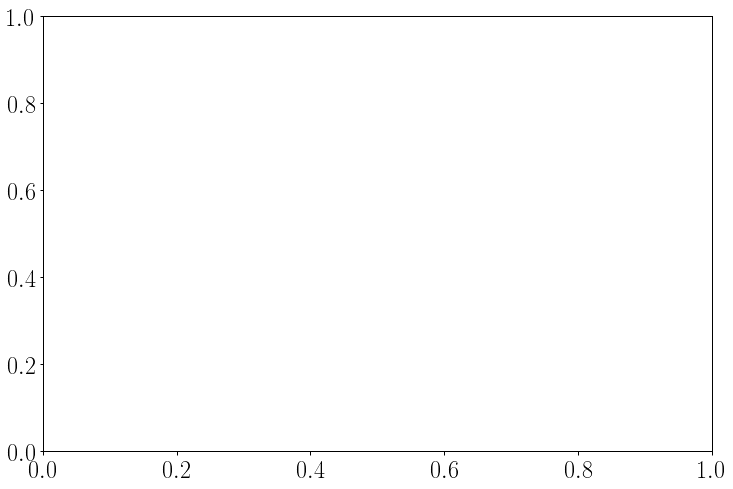

In [9]:
fig, ax = fig_setup(1,1,(12,8),(.3,.3))
FONTSIZE=30
width=0.125
ax1_tc = df_tc[[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                 'RTS overhead', 'EnTK management overhead', 'EnTK adaptivity overhead',
                 'Execution time']].plot(
                     kind='bar', 
                     ax=ax[0][0],
                     yerr=df_tc_err,
                     fontsize=FONTSIZE,
                     width=5*width,
                     legend=False,
                     logy=True,
                     color = [tableau20[1],tableau20[3],tableau20[5],tableau20[7],
                             tableau20[9],tableau20[10],tableau20[13]],
                     ylim=(0.001,10000))

# ax2_tc = df_tc['Execution time'].plot(ax=ax[0][0], 
#                                         legend=False,
#                                         yerr = df_tc_err['Execution time'],
#                                         kind='bar', 
#                                         secondary_y=True,
#                                         width=width,
#                                         rot=0,
#                                         color=tableau20[10],
#                                         position=0)

ax1_tc.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
tc_xlabel = ax1_tc.set_xlabel('(a) Number of instances of task-count adaptation during runtime', fontsize=FONTSIZE)
# ax1_tc.set_title(ax1_tc.get_title(), fontsize=FONTSIZE)
# ax2_tc.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
# ax2_tc.set_ylim(0,6000)
# plt.gca().set_xlim([-1.,2.5])



# plt.setp([a.get_xticklabels() for a in ax[0]], visible=True)
# plt.setp([tc_xlabel, to_xlabel], visible=True)

# plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=True)
# plt.setp([df1_xlabel, df2_xlabel], visible=True)



h1, l1 = ax1_tc.get_legend_handles_labels()
# h2, l2 = ax2_tc.get_legend_handles_labels()
labels = ['EnTK Setup Overhead', 
          'EnTK Tear-Down Overhead', 
          'RTS Tear-Down Overhead',
          'RTS Overhead',
          'EnTK Management Overhead',
          'EnTK Adaptivity Overhead',          
          'Task Execution Time (right)']
# handles = h1 + h2
handles = h1
# plt.legend(handles, labels, loc = 'lower center', bbox_to_anchor = (0.01,-0.1,1,1), bbox_transform = plt.gcf().transFigure, ncol=2, fontsize=FONTSIZE )

fig.savefig('../plots/vary_tasks_adap_overheads_stress_supermic.pdf', dpi=100, bbox_inches='tight')
fig.savefig('../plots/vary_tasks_adap_overheads_stress_supermic.png', dpi=100, bbox_inches='tight')